<a href="https://colab.research.google.com/github/BrendaG04/Google1D/blob/main/notebooks/KR_Notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# 2. Load Dataset

In [11]:
file_path = '../datasets/KR_youtube_trending_data.csv'
df = pd.read_csv(file_path, on_bad_lines='skip', engine='python')
df.head()

,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,uq5LClQN3cE,안녕하세요 보겸입니다,2020-08-09T09:32:48Z,UCu9BCtGIEr73LXZsKmoujKw,보겸 BK,24,2020-08-12T00:00:00Z,보겸|bokyem,5947503,53326,105756,139946,https://i.ytimg.com/vi/uq5LClQN3cE/default.jpg,False,False,NaN
1,I-ZbZCHsHD0,부락토스의 계획 [총몇명 프리퀄],2020-08-12T09:00:08Z,UCRuSxVu4iqTK5kCh90ntAgA,총몇명,1,2020-08-12T00:00:00Z,총몇명|재밌는 만화|부락토스|루시퍼|총몇명 프리퀄|총몇명 스토리,963384,28244,494,3339,https://i.ytimg.com/vi/I-ZbZCHsHD0/default.jpg,False,False,"오늘도 정말 감사드립니다!!총몇명 스튜디오 - 총몇명, 십제곱, 5G민, MOVE혁..."
2,9d7jNUjBoss,평생 반성하면서 살겠습니다.,2020-08-10T09:54:13Z,UCMVC92EOs9yDJG5JS-CMesQ,양팡 YangPang,22,2020-08-12T00:00:00Z,양팡|양팡유튜브|팡튜브|가족시트콤|양팡가족|양팡가족시트콤|양팡언니|현실남매|현실자매...,2950885,17974,68898,50688,https://i.ytimg.com/vi/9d7jNUjBoss/default.jpg,False,False,NaN
3,3pI_L3-sMVg,안녕하세요 꽈뚜룹입니다.,2020-08-11T15:00:58Z,UCkQCwnkQfgSuPTTnw_Y7v7w,꽈뚜룹 Quaddurup,24,2020-08-12T00:00:00Z,꽈뚜룹|한국여행기|quaddurup|뚜룹이|korea|southkorea|vlog|...,1743374,36893,1798,8751,https://i.ytimg.com/vi/3pI_L3-sMVg/default.jpg,False,False,앞으로 좀 더 깔끔한 영상제작 약속 드리겠습니다.늘 감사드립니다
4,zrsBjYukE8s,박진영 (J.Y. Park) When We Disco (Duet with 선미) M/V,2020-08-11T09:00:13Z,UCaO6TYtlC8U5ttz62hTrZgg,JYP Entertainment,10,2020-08-12T00:00:00Z,JYP Entertainment|JYP|J.Y.Park|JYPark|박진영|선미|S...,3433885,353337,9763,23405,https://i.ytimg.com/vi/zrsBjYukE8s/default.jpg,False,False,MelOn http://kko.to/TWyXd7zYjSpotify https://s...


# 3. Initial Inspection

In [12]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Data Types:\n", df.dtypes)
print("Missing Values:\n", df.isnull().sum())
print("Duplicate Rows:", df.duplicated().sum())

Shape: (265754, 16)
Columns: ['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId', 'trending_date', 'tags', 'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'description']
Data Types:
 video_id             object
title                object
publishedAt          object
channelId            object
channelTitle         object
categoryId            int64
trending_date        object
tags                 object
view_count            int64
likes                 int64
dislikes              int64
comment_count         int64
thumbnail_link       object
comments_disabled      bool
ratings_disabled       bool
description          object
dtype: object
Missing Values:
 video_id                0
title                   0
publishedAt             0
channelId               0
channelTitle            0
categoryId              0
trending_date           0
tags                    0
view_count              0
likes         

In [ ]:
df.shape

(265754, 16)

# 4. Drop Duplicates

In [15]:
df = df.drop_duplicates(subset=['video_id', 'trending_date'])
print("Shape after dropping duplicates:", df.shape)

Shape after dropping duplicates: (262065, 16)


# 5. Convert Dates & Create Time Features

In [16]:
# convert to datetime
df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors = 'coerce')
df['trending_date'] = pd.to_datetime(df['trending_date'], errors = 'coerce')

# Days between publish and trending
df['days_to_trend'] = (df['trending_date'] - df['publishedAt']).dt.days
df['days_to_trend'] = df['days_to_trend'].apply(lambda x: x if x >= 0 else np.nan)

# Day of week (0 = Monday) and publish hour
df['publish_dayofweek'] = df['publishedAt'].dt.dayofweek
df['publish_hour'] = df['publishedAt'].dt.hour

# Check result
df[['publishedAt', 'trending_date', 'days_to_trend', 'publish_dayofweek', 'publish_hour']].head()

,publishedAt,trending_date,days_to_trend,publish_dayofweek,publish_hour
0,2020-08-09 09:32:48+00:00,2020-08-12 00:00:00+00:00,2.0,6,9
1,2020-08-12 09:00:08+00:00,2020-08-12 00:00:00+00:00,NaN,2,9
2,2020-08-10 09:54:13+00:00,2020-08-12 00:00:00+00:00,1.0,0,9
3,2020-08-11 15:00:58+00:00,2020-08-12 00:00:00+00:00,0.0,1,15
4,2020-08-11 09:00:13+00:00,2020-08-12 00:00:00+00:00,0.0,1,9


In [17]:
df[['publishedAt', 'trending_date', 'days_to_trend']].describe()

,days_to_trend
count,260504.000000
mean,5.745298
std,3.991724
min,0.000000
25%,2.000000
50%,5.000000
75%,8.000000
max,29.000000


# 6. Transform Skewed Numerical Features

In [18]:
import numpy as np

for col in ['view_count', 'likes', 'dislikes', 'comment_count']:
    df[f'log_{col}'] = np.log1p(df[col])

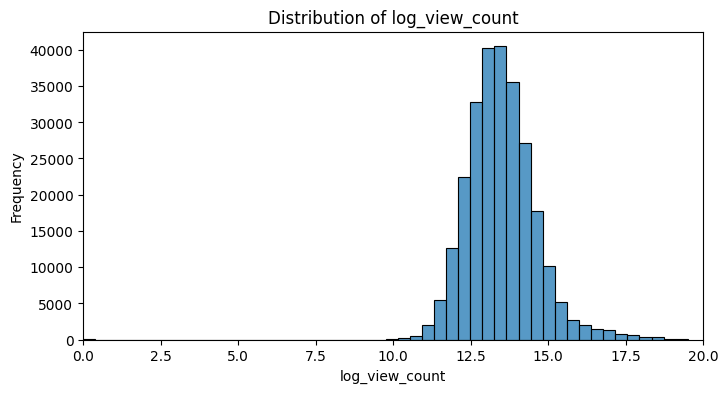

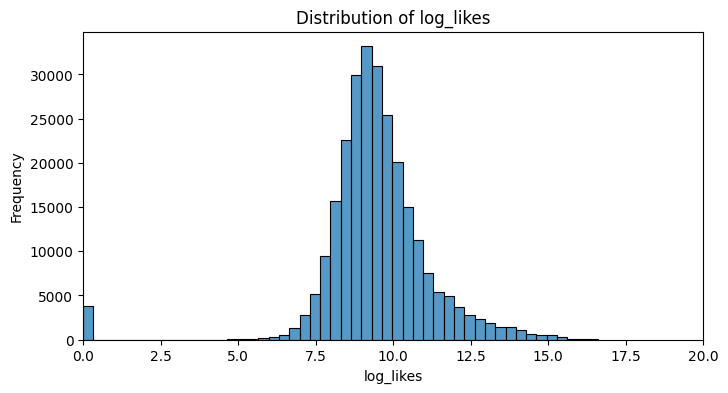

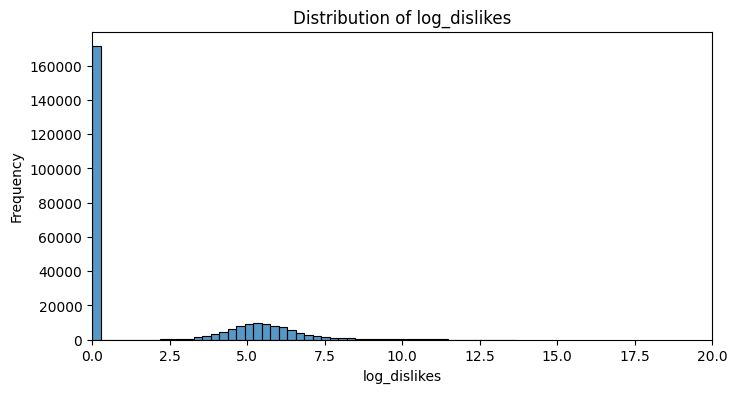

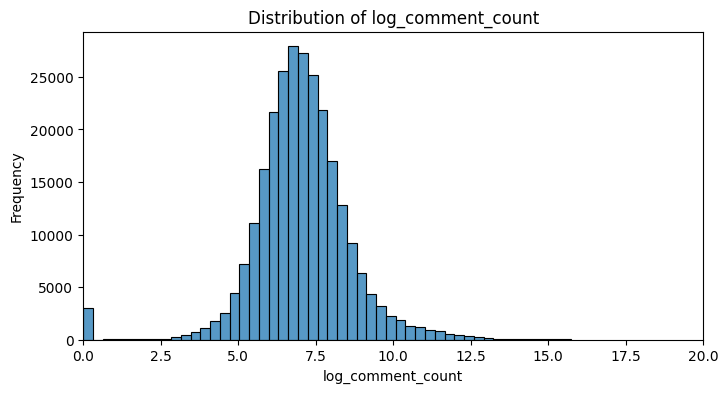

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

for col in ['log_view_count', 'log_likes', 'log_dislikes', 'log_comment_count']:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xlim(0, 20) # adjust if needed
    plt.show()

## Log-Transformed Distribution Insights

-   log_view_count: Normal-ish distribution, peak around 13
-   log_likes: Also approximately normal, centered around 9-10
-   log_dislikes: Very skewed -- lots of zeros and very low counts
-   log_comment_count: Slight right skew, but generally normal-ish, centered around 7-8

# 7. Correlation Analysis

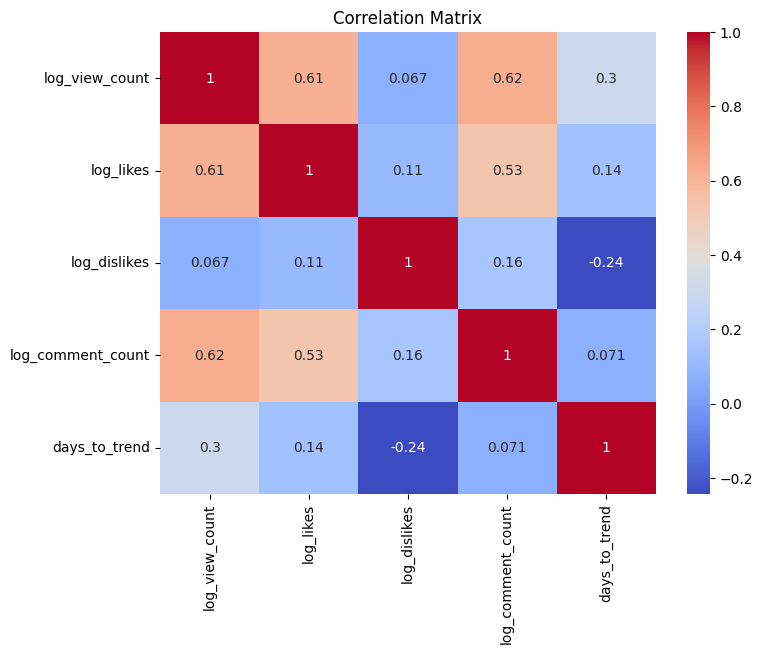

In [20]:
# check how log-transformed features relate to days_to_trend
# Example: Select only numerical columns for correlation
num_cols = ['log_view_count', 'log_likes', 'log_dislikes', 'log_comment_count', 'days_to_trend']
corr_matrix = df[num_cols].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Few Important Insights

log_view_count with days_to_trend : +0.30 / slight positive correlation: more views -> tend to trend slightly later

log_dislikes : -0.24 / moderat negative: more dislikes -> trend sooner. Interesting signal.

    -   The strongest signal is log_dislike -- videos with more dislikes tend to trend earlier. This may reflect controversial or viral content.
    -   log_view_count has some predictive power, but it's weak. 

# 8. Classification

In [21]:
# Define target: went viral if it trended in 3 days or fewer
# Define went_viral = 1 if video trended quickly (say, within 3 days), and 0 otherwise:
df['went_viral'] = (df['days_to_trend'] <= 3).astype(int)
# check class distribution
print(df['went_viral'].value_counts(normalize=True)) # see if it's balanced

went_viral
0    0.667819
1    0.332181
Name: proportion, dtype: float64


In [22]:
features = ['log_view_count', 'log_likes', 'log_dislikes', 'log_comment_count']
target = 'went_viral'

X = df[features]
y = df[target]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, stratify=y, random_state=42
)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# initialize and fit model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# predict on test data
y_pred = model.predict(X_test)

# Evaluate
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.93      0.80     35002
           1       0.60      0.22      0.32     17411

    accuracy                           0.69     52413
   macro avg       0.65      0.57      0.56     52413
weighted avg       0.67      0.69      0.64     52413

[[32461  2541]
 [13615  3796]]


-   Model is good at finding non-viral videos (class 0) 
-   But missing most viral videos (class 1) (recall: 0.22) / not good

model is biased toward predicting "not viral"

In [25]:
# class_weight = 'balanced' in Logistic Regression

model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.62      0.69     35002
           1       0.46      0.64      0.53     17411

    accuracy                           0.63     52413
   macro avg       0.62      0.63      0.61     52413
weighted avg       0.67      0.63      0.64     52413



In [26]:
# Try Tree-Based Model 
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.76      0.91      0.82     35002
           1       0.68      0.41      0.51     17411

    accuracy                           0.74     52413
   macro avg       0.72      0.66      0.67     52413
weighted avg       0.73      0.74      0.72     52413



## Interpretation

-   Logitsitc Regression (class_weight = 'balanced')
    -   Best recall for viral videos (0.64) -> finds more true positives
    -   But more false postiives -> lower precision (0.46)
    -   Use if you care about catching as many viral videos as possible

-   Random Forest (class_weight = 'balanced')
    -   Best overall performance (accuracy : 74%, weighted F1: 0.72)
    -   Better precision (0.68) -> more confident predictions of viral videos
    -   But lower recall (0.41) -> misses more viral videos

## Next Step

-   prioritize recall using LR to detect more viral content, but we also evaluate random forest model offering better precision and accuracy overall.



# 9. Feature Importance

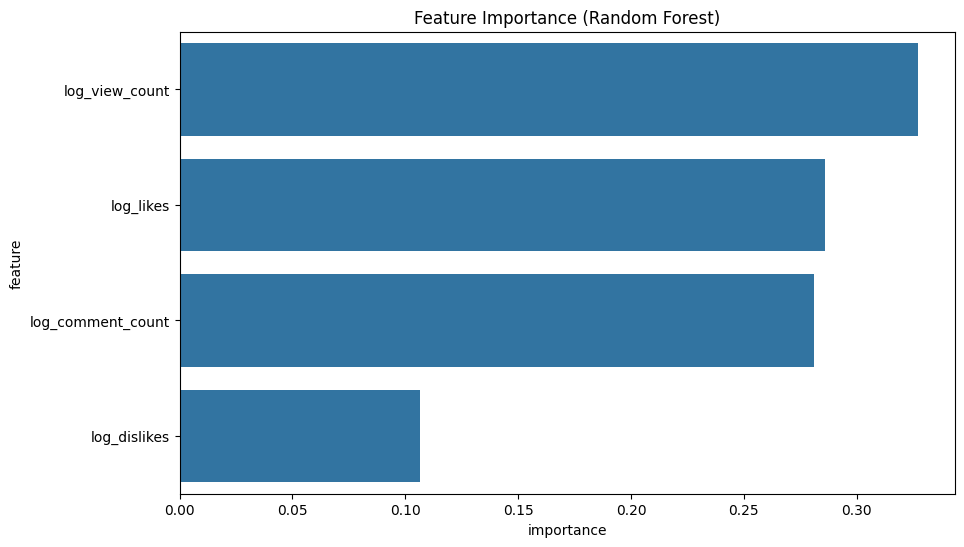

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# get feature importance scores
importances = rf.feature_importances_
feature_names = X_train.columns

# DataFrame
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y = 'feature', data=feat_imp_df)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout
plt.show()

1. log_view_count
    -   most important predictor of whether video goes viral
    -   makes intuitive sense -- videos that are already getting lots of views tend to trend
2. log_likes and log_comment_count
    -   strong signals of engagement
    -   likes and comments reflect user approval and interaction
3. log_dislikes
    -   lowest importance
    -   even hidden public dislike counts, so this may reflect real-world changes

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(f"\n{name}")
    print(classification_report(y_test, preds))


Logistic Regression
              precision    recall  f1-score   support

           0       0.70      0.93      0.80     35002
           1       0.60      0.22      0.32     17411

    accuracy                           0.69     52413
   macro avg       0.65      0.57      0.56     52413
weighted avg       0.67      0.69      0.64     52413


SVM
              precision    recall  f1-score   support

           0       0.69      0.95      0.80     35002
           1       0.62      0.16      0.25     17411

    accuracy                           0.69     52413
   macro avg       0.66      0.55      0.53     52413
weighted avg       0.67      0.69      0.62     52413


Gradient Boosting
              precision    recall  f1-score   support

           0       0.71      0.91      0.80     35002
           1       0.60      0.26      0.37     17411

    accuracy                           0.70     52413
   macro avg       0.66      0.59      0.58     52413
weighted avg       0.68      

Will choose 'Random Forest' -- strongest F1-score for viral class (1), better recall catching more actual viral videos, maintains good overall accuracy and balance across classes